In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')


## Loading data

In [2]:
# data = pd.read_csv("hf://datasets/dirtycomputer/Automated_Hate_Speech_Detection_and_the_Problem_of_Offensive_Language/labeled_data.csv")
data = pd.read_csv('./processed_data/processed_toxic_comments.csv')
data.sample(5)

,processed_tweet,class
14746,rt rt if u remember when steve from...,1
7804,are pet guinea pig is about to die this fuckin...,1
15546,rt if she doesn t take it in the ass tell t...,1
2697,lmao u ain t a savage thes...,1
19358,rt jessica i m not afraid to slit...,0


In [ ]:
data.shape

(24783, 7)

## Splitting Data for Training and Testing


In [4]:
X = data['processed_tweet']
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((19826,), (4957,), (19826,), (4957,))

## Initializing BERT Tokenizer

In [5]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Creating Dataset Class

In [6]:
class ToxicCommentsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        text = self.texts[idx]
        if not isinstance(text, str):
          text = str(text)
        inputs = tokenizer(text, padding='max_length', max_length=64, truncation=True, return_tensors="pt")
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze(), label

### Wrapping training and test data in PyTorch Dataset objects.


In [7]:
train_dataset = ToxicCommentsDataset(X_train.tolist(), y_train)
test_dataset = ToxicCommentsDataset(X_test.tolist(), y_test)

### Preparing DataLoaders for efficient batch processing.

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Defining Toxic Comment Classifier



In [10]:
import torch
import torch.nn as nn
from transformers import DistilBertModel

class ToxicCommentClassifier(nn.Module):
    def __init__(self):
        super(ToxicCommentClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Unfreeze the last few layers of DistilBERT
        for name, param in self.distilbert.named_parameters():
            if "transformer.layer.4" in name or "transformer.layer.5" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.fc_1 = nn.Linear(768, 512)
        self.fc_2 = nn.Linear(512, 128)
        self.fc_3 = nn.Linear(128, 3)  # Output for 3 classes

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.layer_norm = nn.LayerNorm(512)

    def forward(self, input_ids, attention_mask):
        # Pass through DistilBERT
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # Extract [CLS] token output

        out = self.fc_1(cls_output)
        out = self.layer_norm(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc_2(out)
        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc_3(out)
        return out



## Model Setup

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ToxicCommentClassifier().to(device)
print(device)

cuda


In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Initialize the learning rate scheduler
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)  # Reduce LR by 10% every 5 epochs


## Training Loop

In [21]:


# Path to save the model
save_path = "best_Model.pth"


for epoch in range(20):
    # Training phase
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch + 1} - Training")
        for input_ids, attention_mask, labels in tepoch:
            input_ids, attention_mask, labels = (
                input_ids.to(device),
                attention_mask.to(device),
                labels.to(device),
            )

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            tepoch.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # Save model if training loss <= 0.3
    if avg_train_loss <= 0.3:
        print(f"Training Loss < 0.3. Saving model at epoch {epoch + 1}...")
        torch.save(model.state_dict(), save_path)

    model.eval()
    val_loss = 0
    y_pred, y_true = [], []
    with tqdm(test_loader, unit="batch") as vepoch:
        vepoch.set_description(f"Epoch {epoch + 1} - Validation")
        with torch.no_grad():
            for input_ids, attention_mask, labels in vepoch:
                input_ids, attention_mask, labels = (
                    input_ids.to(device),
                    attention_mask.to(device),
                    labels.to(device),
                )
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                y_pred.extend(preds.cpu().numpy())
                y_true.extend(labels.cpu().numpy())

                vepoch.set_postfix(loss=loss.item())

    val_loss /= len(test_loader)
    accuracy = sum(1 for x, y in zip(y_pred, y_true) if x == y) / len(y_true)

    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.2f}")

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch + 1}, Learning Rate: {current_lr}")



Epoch 1 - Training: 100%|██████████| 620/620 [01:08<00:00,  9.04batch/s, loss=0.671]


Epoch 1, Training Loss: 0.3284367823372445


Epoch 1 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.49batch/s, loss=0.188]


Epoch 1, Validation Loss: 0.2592, Validation Accuracy: 0.90
Epoch 1, Learning Rate: 0.0001


Epoch 2 - Training: 100%|██████████| 620/620 [01:00<00:00, 10.17batch/s, loss=0.153]


Epoch 2, Training Loss: 0.2468959797053568
Training Loss < 0.3. Saving model at epoch 2...


Epoch 2 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.34batch/s, loss=0.208]


Epoch 2, Validation Loss: 0.2459, Validation Accuracy: 0.91
Epoch 2, Learning Rate: 0.0001


Epoch 3 - Training:   6%|▌         | 36/620 [00:03<00:58, 10.04batch/s, loss=0.0678]


KeyboardInterrupt: 

In [ ]:
# torch.save(model.state_dict(), "toxic_comment_model.pth")

In [ ]:
# log.txt
"""
Epoch 1 - Training: 100%|██████████| 620/620 [01:05<00:00,  9.41batch/s, loss=0.115]
Epoch 1, Training Loss: 0.3114450721190341
Epoch 1 - Validation: 100%|██████████| 155/155 [00:10<00:00, 15.21batch/s, loss=0.19]
Epoch 1, Validation Loss: 0.2621, Validation Accuracy: 0.91
Epoch 1, Learning Rate: 0.0001
Epoch 2 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.68batch/s, loss=0.201]
Epoch 2, Training Loss: 0.24053236350056625
Training Loss < 0.3. Saving model at epoch 2...
Epoch 2 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.64batch/s, loss=0.222]
Epoch 2, Validation Loss: 0.2414, Validation Accuracy: 0.92
Epoch 2, Learning Rate: 0.0001
Epoch 3 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.61batch/s, loss=0.219]
Epoch 3, Training Loss: 0.2172438312261816
Training Loss < 0.3. Saving model at epoch 3...
Epoch 3 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.97batch/s, loss=0.18]
Epoch 3, Validation Loss: 0.2585, Validation Accuracy: 0.90
Epoch 3, Learning Rate: 0.0001
Epoch 4 - Training: 100%|██████████| 620/620 [01:06<00:00,  9.33batch/s, loss=0.751]
Epoch 4, Training Loss: 0.19502148372872222
Training Loss < 0.3. Saving model at epoch 4...
Epoch 4 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.95batch/s, loss=0.213]
Epoch 4, Validation Loss: 0.2743, Validation Accuracy: 0.91
Epoch 4, Learning Rate: 0.0001
Epoch 5 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.62batch/s, loss=0.084]
Epoch 5, Training Loss: 0.17181494032904024
Training Loss < 0.3. Saving model at epoch 5...
Epoch 5 - Validation: 100%|██████████| 155/155 [00:10<00:00, 14.94batch/s, loss=0.163]
Epoch 5, Validation Loss: 0.2865, Validation Accuracy: 0.89
Epoch 5, Learning Rate: 6e-05
Epoch 6 - Training: 100%|██████████| 620/620 [01:04<00:00,  9.65batch/s, loss=0.27]
Epoch 6, Training Loss: 0.13215160482533037
Training Loss < 0.3. Saving model at epoch 6...
Epoch 6 - Validation:  31%|███       | 48/155 [00:03<00:07, 15.14batch/s, loss=0.12]



"""


## Evaluation

In [14]:
# Evaluation
model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

In [15]:
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9108331652208997


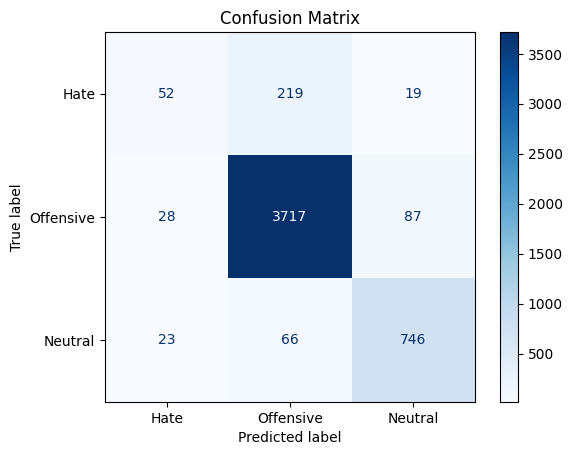

In [16]:


# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ['Hate', 'Offensive', 'Neutral']

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Final Prediction Function

In [17]:
# Prediction function

def predict_toxicity(comment):
    model.eval()
    inputs = tokenizer(comment, padding='max_length', max_length=128, truncation=True, return_tensors="pt")
    input_ids, attention_mask = inputs['input_ids'].to(device), inputs['attention_mask'].to(device)

    with torch.no_grad():
        output = model(input_ids, attention_mask)
        _, prediction = torch.max(output, dim=1)

    if prediction.item() == 0:
        return 'Hate'
    elif prediction.item() == 1:
        return 'Offensive'
    else:
        return 'Neutral'


In [18]:
# Example prediction
comment = "It is raining in Mumbai"
print("Prediction:", predict_toxicity(comment))

Prediction: Neutral


In [ ]:
# Save the trained model
# torch.save(model.state_dict(), "toxic_comment_model.pth")